### Load Data

In [ ]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("canonwu/mnistpkl")

print("Path to dataset files:", path)

/mnt/anaconda3/envs/vae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 32.9M/32.9M [00:02<00:00, 16.6MB/s]

Extracting files...


Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/canonwu/mnistpkl/versions/1


In [7]:
#Load MNIST
from torchvision.datasets import MNIST
import numpy as np

# Load train and test datasets
train_dataset = MNIST(root="./data", train=True, download=True)
test_dataset = MNIST(root="./data", train=False, download=True)

# Extract image data from both sets and convert to NumPy arrays
train_images = np.stack([np.array(img, dtype=np.uint8) for img, _ in train_dataset])  # (60000, 28, 28)
test_images = np.stack([np.array(img, dtype=np.uint8) for img, _ in test_dataset])    # (10000, 28, 28)

# Combine into one variable
all_images = np.concatenate([train_images, test_images], axis=0)  # (70000, 28, 28)

In [8]:
all_images.shape

(70000, 28, 28)

In [2]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [3]:
import numpy as np

In [4]:
for t in train_dataset:
    print(t)
    break

(<PIL.Image.Image image mode=L size=28x28 at 0x7FD029EA74C0>, 5)


In [5]:
t[0]

### Plot Training Loss

In [33]:
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [39]:
save_path = "./output/model"
loss_per_epoch = {}

for epoch_num in tqdm(range(len(os.listdir(save_path)))):

    file_path = os.path.join(save_path, f"new_model_epoch_{epoch_num}.pt")

    d = torch.load(file_path)
    loss_per_epoch[d["epoch"]] = d["loss"].detach().cpu().numpy()

100%|██████████| 78/78 [00:03<00:00, 25.88it/s]


In [40]:
loss_per_epoch

{0: array(363.01096, dtype=float32),
 1: array(304.42712, dtype=float32),
 2: array(291.22345, dtype=float32),
 3: array(251.32732, dtype=float32),
 4: array(289.73608, dtype=float32),
 5: array(313.57166, dtype=float32),
 6: array(281.04184, dtype=float32),
 7: array(281.94226, dtype=float32),
 8: array(310.62753, dtype=float32),
 9: array(268.46103, dtype=float32),
 10: array(302.4469, dtype=float32),
 11: array(267.3105, dtype=float32),
 12: array(253.70848, dtype=float32),
 13: array(261.2951, dtype=float32),
 14: array(248.49944, dtype=float32),
 15: array(255.25061, dtype=float32),
 16: array(245.83911, dtype=float32),
 17: array(250.90002, dtype=float32),
 18: array(253.63571, dtype=float32),
 19: array(252.25339, dtype=float32),
 20: array(240.15587, dtype=float32),
 21: array(252.888, dtype=float32),
 22: array(235.13322, dtype=float32),
 23: array(251.71252, dtype=float32),
 24: array(257.51852, dtype=float32),
 25: array(258.51404, dtype=float32),
 26: array(258.9841, dtype=

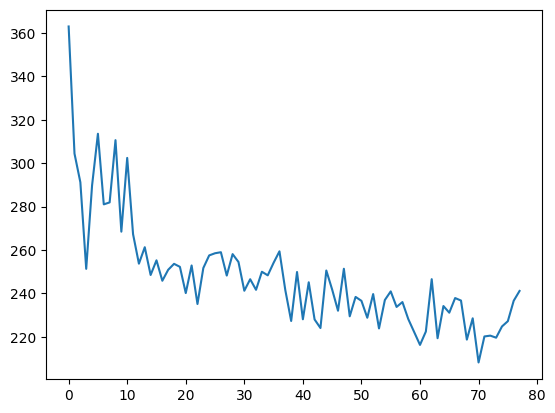

In [41]:
plt.plot(loss_per_epoch.keys(), loss_per_epoch.values())